In [1]:
# import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load dataset ve EDA
df = pd.read_csv("datasets/heart_disease_uci.csv")
df = df.drop(columns = ["id"])

df.info()

describe = df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    int64  
 1   sex       920 non-null    object 
 2   dataset   920 non-null    object 
 3   cp        920 non-null    object 
 4   trestbps  861 non-null    float64
 5   chol      890 non-null    float64
 6   fbs       830 non-null    object 
 7   restecg   918 non-null    object 
 8   thalch    865 non-null    float64
 9   exang     865 non-null    object 
 10  oldpeak   858 non-null    float64
 11  slope     611 non-null    object 
 12  ca        309 non-null    float64
 13  thal      434 non-null    object 
 14  num       920 non-null    int64  
dtypes: float64(5), int64(2), object(8)
memory usage: 107.9+ KB


In [4]:
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_features

['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca', 'num']

<Figure size 640x480 with 0 Axes>

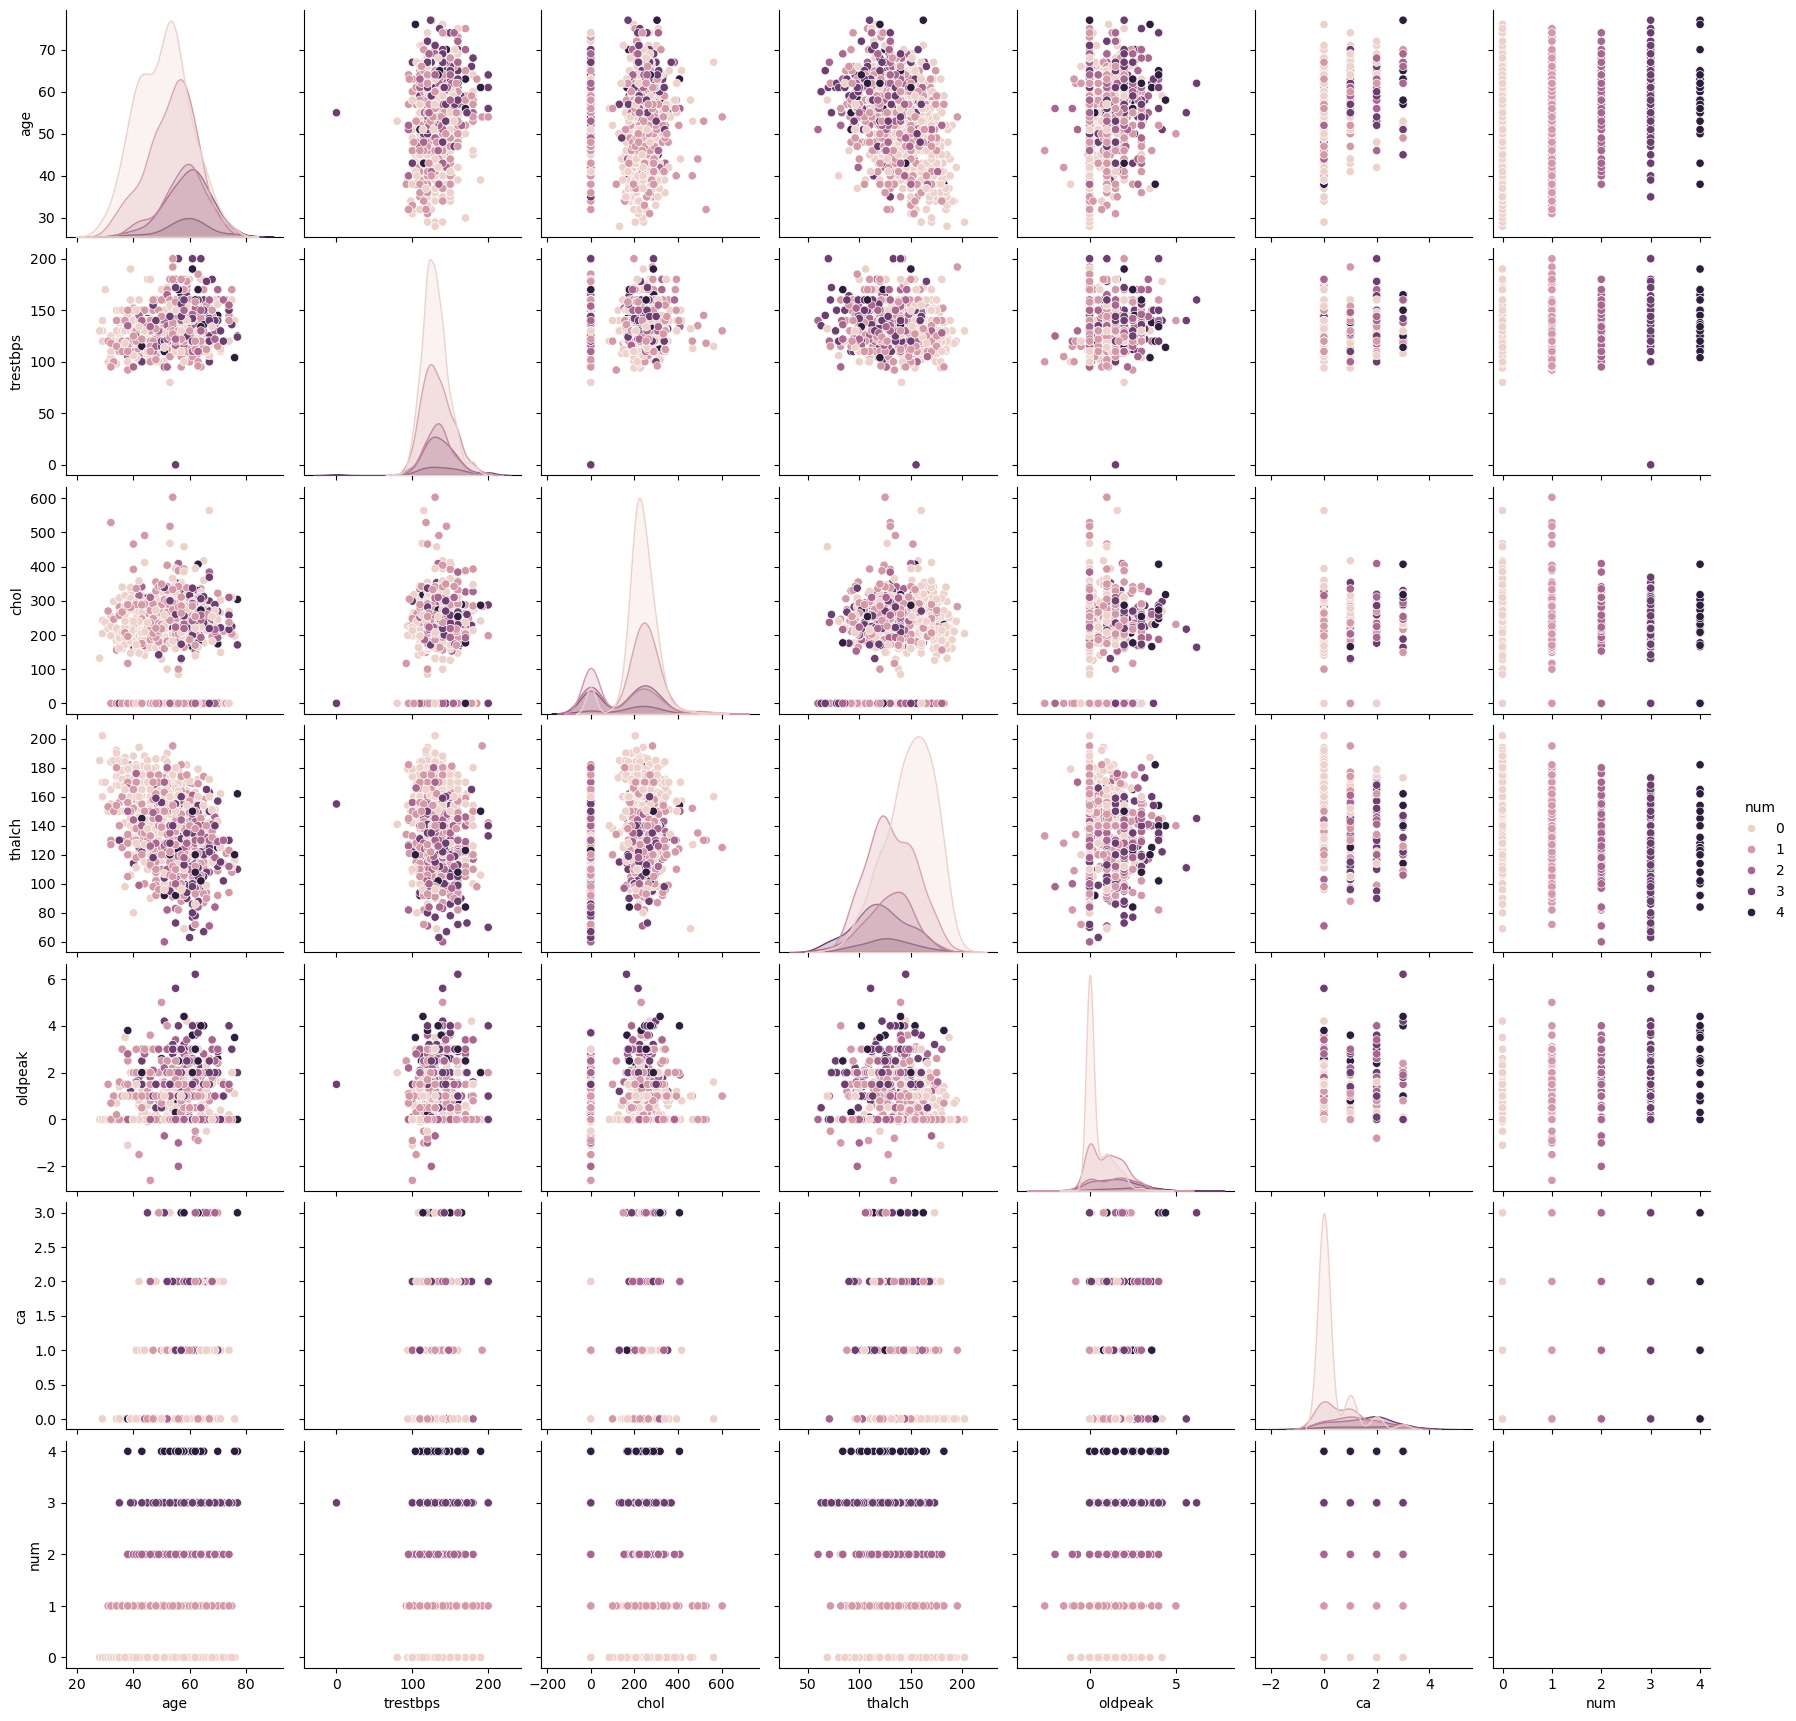

In [5]:
plt.figure()
sns.pairplot(df, vars=numerical_features, hue = "num")
plt.show()

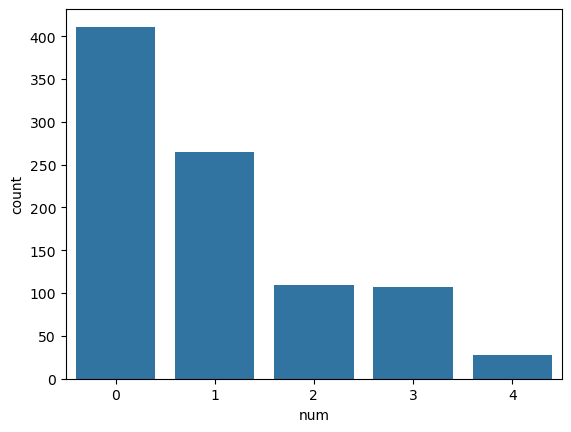

In [6]:
plt.figure()
sns.countplot(x="num", data = df)
plt.show()

In [7]:
# handling missing value
print(df.isnull().sum())
df = df.drop(columns = ["ca"])
print(df.isnull().sum())
df["trestbps"].fillna(df["trestbps"].median(), inplace = True)
df["chol"].fillna(df["chol"].median(), inplace = True)
df["fbs"].fillna(df["fbs"].mode()[0], inplace = True)
df["restecg"].fillna(df["restecg"].mode()[0], inplace = True)
df["thalch"].fillna(df["thalch"].median(), inplace = True)
df["exang"].fillna(df["exang"].mode()[0], inplace = True)
df["oldpeak"].fillna(df["oldpeak"].median(), inplace = True)
df["slope"].fillna(df["slope"].mode()[0], inplace = True)
df["thal"].fillna(df["thal"].mode()[0], inplace = True)

print(df.isnull().sum())

age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
thal        486
num           0
dtype: int64
age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
thal        0
num         0
dtype: int64


In [8]:
# train test split - standardizasyon - kategorik kodlama
X = df.drop(["num"], axis=1)
y = df["num"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

categorical_features = ["sex", "dataset", "cp", "restecg", "exang", "slope", "thal"]
numerical_features = ["age", "trestbps", "chol", "fbs", "thalch", "oldpeak"]

X_train_num = X_train[numerical_features]
X_test_num = X_test[numerical_features]

scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

encoder = OneHotEncoder(sparse=False, drop="first")
X_train_cat = X_train[categorical_features]
X_test_cat = X_test[categorical_features]

X_train_cat_encoded = encoder.fit_transform(X_train_cat)
X_test_cat_encoded = encoder.transform(X_test_cat)

X_train_transformed = np.hstack((X_train_num_scaled, X_train_cat_encoded))
X_test_transformed = np.hstack((X_test_num_scaled, X_test_cat_encoded))

In [9]:
# modelling: RF, KNN, Voting Classifier train ve test
rf = RandomForestClassifier(n_estimators=100, random_state=42)
knn = KNeighborsClassifier()

voting_clf = VotingClassifier(estimators=[
    ("rf",rf),
    ("knn",knn)], voting="soft")


In [10]:
# model egitimi
voting_clf.fit(X_train_transformed, y_train)

# test verisi ile tahmin yap
y_pred = voting_clf.predict(X_test_transformed)

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Confusion Matrix: ")
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("Classification Report: ")
print(classification_report(y_test, y_pred))

Accuracy:  0.5608695652173913
Confusion Matrix: 
[[78 12  5  1  0]
 [17 35  5  7  0]
 [ 3 14  9  5  0]
 [ 9 12  4  7  0]
 [ 1  2  2  2  0]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.72      0.81      0.76        96
           1       0.47      0.55      0.50        64
           2       0.36      0.29      0.32        31
           3       0.32      0.22      0.26        32
           4       0.00      0.00      0.00         7

    accuracy                           0.56       230
   macro avg       0.37      0.37      0.37       230
weighted avg       0.52      0.56      0.54       230



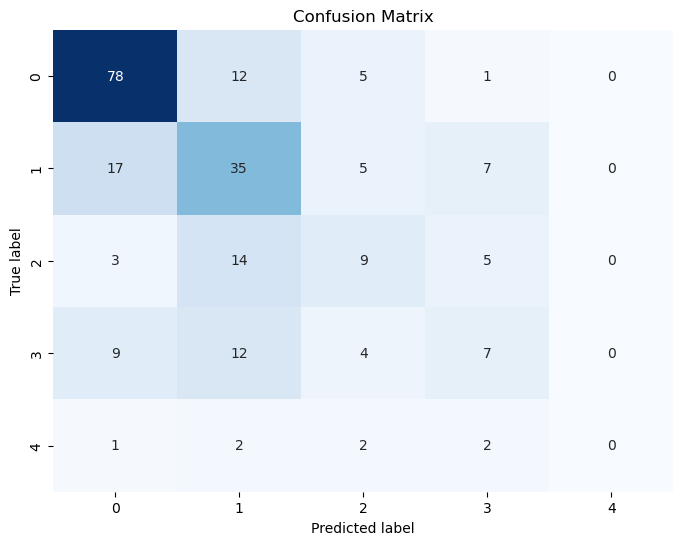

In [11]:
# CM
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot = True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()